# Explore the construction events in Batch 1

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

In [2]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [3]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

# * Assessor parcel data
assessor_parcels = gpd.read_file(os.path.join(INPUT_FP, 'AssessorData', 'assessor_scc_parcels.geojson'))
sj_assessor_parcels = assessor_parcels.loc[assessor_parcels['SITUS_CITY'] == 'SAN JOSE'].copy()
del assessor_parcels

# Keep only parcel data
sj_assessor_parcels = sj_assessor_parcels.loc[sj_assessor_parcels['FEATURE'] == 'PAR']
sj_assessor_parcels = sj_assessor_parcels[[
    'OBJECTID', 'APN', 'LAND', 'IMPROVEMEN', 'geometry']].copy()

In [64]:
# * Historical Assessor data ()
assessor_historical = pd.read_csv(
    '/oak/stanford/groups/deho/corelogic/data/final/CA/SC_county_2018_Tax.txt', 
    delimiter='|', low_memory=False)

In [7]:
# Inputs from processing Batch 1
new_sbuild_2020 = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B1-100', 'permit-matching-apns-CF-min11-GT1.csv'), 
    dtype={'APN': str})

# Add CBG-income data
new_sbuild_2020_cbg = pd.merge(
    new_sbuild_2020, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

# * Generate quartile and neighborhood columns for each CBG
if 'neighborho' in cbg_income_2016_SJ.columns:
    cbg_income_2016_SJ.drop('neighborho', axis=1, inplace=True)

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

cbg_income_2016_SJ['quartile'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_names[quartile])
 
new_sbuild_2020_cbg = pd.merge(
    new_sbuild_2020_cbg, cbg_income_2016_SJ[['GEOID', 'median_inc', 'quartile']], 
    on='GEOID', how='left', validate='many_to_one')

## Parcel-level

In [8]:
new_sbuild_parcel_perm = new_sbuild_2020_cbg.loc[new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0].copy()
new_sbuild_parcel_perm = new_sbuild_parcel_perm.loc[
    new_sbuild_parcel_perm.index.repeat(new_sbuild_parcel_perm.count_new_sbuild_permitted)]
new_sbuild_parcel_perm['Permitted'] = 1

new_sbuild_parcel_unperm = new_sbuild_2020_cbg.loc[new_sbuild_2020_cbg['count_new_sbuild_unpermitted'] > 0].copy()
new_sbuild_parcel_unperm = new_sbuild_parcel_unperm.loc[
    new_sbuild_parcel_unperm.index.repeat(new_sbuild_parcel_unperm.count_new_sbuild_unpermitted)]
new_sbuild_parcel_unperm['Permitted'] = 0

new_sbuild_parcel = pd.concat([new_sbuild_parcel_perm, new_sbuild_parcel_unperm])
new_sbuild_parcel = new_sbuild_parcel[['APN', 'GEOID', 'median_inc', 'quartile', 'Permitted']]

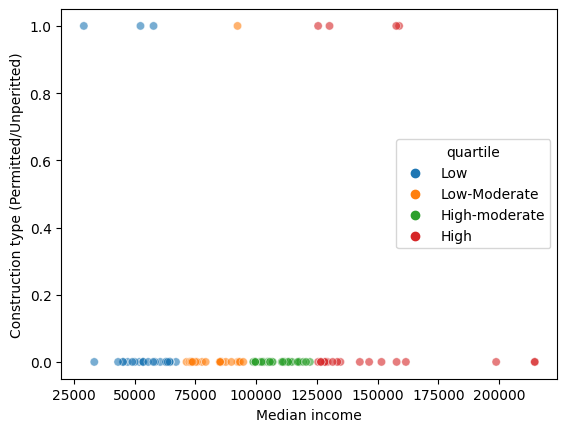

In [9]:
ax = sns.scatterplot(new_sbuild_parcel, x='median_inc', y='Permitted', hue='quartile', alpha=0.6)
ax.set(xlabel='Median income', ylabel='Construction type (Permitted/Unperitted)')
plt.show()

## CBG-level

In [42]:
# Aggregate at the CBG level
new_sbuild_2020_cbg_agg = new_sbuild_2020_cbg.groupby('GEOID').agg(
    {'count_new_sbuild_permitted': 'sum', 'count_new_sbuild': 'sum', 'median_inc': 'mean', 'quartile': 'first'}).reset_index()
new_sbuild_2020_cbg_agg['perm_rate'] = new_sbuild_2020_cbg_agg[
    'count_new_sbuild_permitted'] / new_sbuild_2020_cbg_agg['count_new_sbuild']

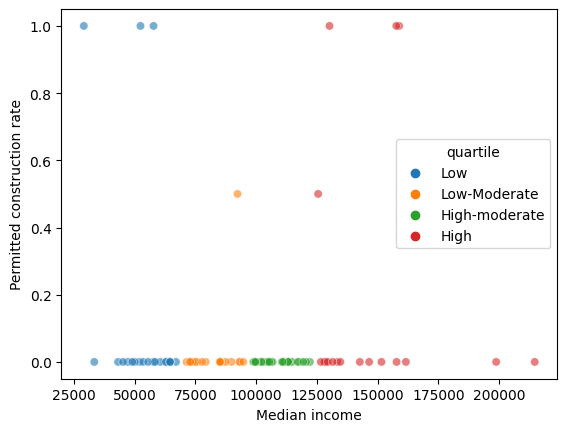

In [43]:
ax = sns.scatterplot(new_sbuild_2020_cbg_agg, x='median_inc', y='perm_rate', hue='quartile', alpha=0.6)
ax.set(xlabel='Median income', ylabel='Permitted construction rate')
plt.show()

## Low-income permitted events

In [44]:
new_sbuild_2020_cbg.loc[
    (new_sbuild_2020_cbg['quartile']!= 'High') & (new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0)]

,APN,count_new_sbuild,pcount_2015_20,count_new_sbuild_permitted,count_new_sbuild_unpermitted,GEOID,median_inc,quartile
11,26435035,1,1.0,1.0,0.0,060855017002,29054.054054,Low
13,26462005,2,1.0,1.0,1.0,060855023022,92308.000000,Low-Moderate
49,48605010,1,1.0,1.0,0.0,060855034012,52371.000000,Low
62,49724012,1,1.0,1.0,0.0,060855032045,57750.000000,Low


In [ ]:
#'26435035'  ok
# 26462005 OK 2nd unit added
# 48605010 seems to just be re-roofing: permit value is 0; sqft is 0
# 49724012 OK

In [80]:
permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(['49724012'])]

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
11962,E_45633,36673,36673,"2943 GARDEN AV 2 , SAN JOSE CA 95111",49724012,QSP CONSTRUCTION,QSP CONSTRUCTION,New Construction,2nd Unit Added,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,465.113276,11854.445748,POLYGON ((-121.84184262220663 37.2926805609769...,2018-06-11 00:00:00,2017,2018


## High-income permitted events

In [81]:
new_sbuild_2020_cbg.loc[
    (new_sbuild_2020_cbg['quartile'] == 'High') & (new_sbuild_2020_cbg['count_new_sbuild_permitted'] > 0)]

,APN,count_new_sbuild,pcount_2015_20,count_new_sbuild_permitted,count_new_sbuild_unpermitted,GEOID,median_inc,quartile
21,30341002,1,1.0,1.0,0.0,060855063014,125481.0,High
32,44626011,1,2.0,1.0,0.0,060855025006,158819.0,High
94,69226014,1,1.0,1.0,0.0,060855120291,130167.0,High
96,70101032,1,1.0,1.0,0.0,060855119072,157652.0,High


In [ ]:
# 30341002 Has 0 permit value and 0 sqft
# 44626011 OK
# 69226014 14k permit value and 0 sqft
# 70101032 15k permit value and 0 sqft

In [91]:
permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(['70101032'])]

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
10397,E_35015,35041,35041,"6468 ALMADEN RD , SAN JOSE CA 95120-1901",70101006,HIJAZI SAMER L,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2016-05-26T21:09:01+00:00,NaN,NaN,610.222632,17999.914119,POLYGON ((-121.86058677763837 37.2211951038365...,2016-12-02 00:00:00,2016,2016


## CBG median income

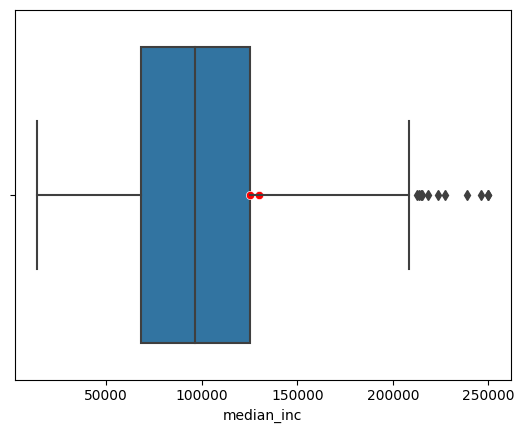

In [45]:
ax = sns.boxplot(cbg_income_2016_SJ, x='median_inc')
ax = sns.scatterplot(cbg_income_2016_SJ.loc[cbg_income_2016_SJ['GEOID'].isin(
    ['060855063014', '060855120291'])], x='median_inc', y=0, ax=ax, color='red')
#ax.axis('off')
plt.show()

## Counterfactual

In [112]:
cbg_income_2016_SJ.loc[cbg_income_2016_SJ['GEOID'].isin(
    ['060855063014', '060855120291'])]

,GEOID,median_inc,strata_inc,neighborho,geometry,median_inc_str
34,060855063014,125481.0,IS_37,high,"POLYGON ((-121.96067 37.31650, -121.96067 37.3...",125481.0
69,060855120291,130167.0,IS_39,high,"POLYGON ((-121.83084 37.25129, -121.83049 37.2...",130167.0


In [118]:
new_sbuild_cf = new_sbuild_2020_cbg.copy()
new_sbuild_cf['neighborhood_counterfactual'] = new_sbuild_cf['median_inc'].apply(
    lambda inc: 'Low' if inc <= 130167.0 else 'High')

In [119]:
new_sbuild_cf.groupby('neighborhood_counterfactual')[[
    'count_new_sbuild_permitted', 'count_new_sbuild']].sum().reset_index()

,neighborhood_counterfactual,count_new_sbuild_permitted,count_new_sbuild
0,High,2.0,13
1,Low,6.0,91


## Using parcel-level "income"

In [132]:
time_period = ['historic', 'latest'][0]

In [133]:
if time_period == 'historic':
    assessor_data = assessor_historical.copy()
    
    # Filter to SJ
    assessor_data = assessor_data.loc[assessor_data['SITUS CITY'] == 'SAN JOSE']
    assessor_data = assessor_data[[
        'APN (PARCEL NUMBER UNFORMATTED)', 'FORMATTED APN', 'ORIGINAL APN', 
        'TOTAL VALUE CALCULATED', 'SITUS CITY']]
    # Most APNs are correctly 8-digit numbers 
    assessor_data['APN'] = assessor_data['APN (PARCEL NUMBER UNFORMATTED)'].apply(
        lambda apn: apn)
    assessor_data['apn_len'] = assessor_data['APN (PARCEL NUMBER UNFORMATTED)'].apply(
        lambda apn: len(apn))
    
    # Filter to residential parcels
    assessor_data = assessor_data.loc[assessor_data['APN'].isin(sj_parcels_cbgs['APN'].unique())]
    
    assessor_data['parcel_income'] = assessor_data['TOTAL VALUE CALCULATED']
    print('[INFO] Number of residential parcels in assessor data: {}'.format(len(assessor_data)))
    
elif time_period == 'latest':
    assessor_data = sj_assessor_parcels.copy()
    assessor_data['parcel_income'] = assessor_data['LAND'] + assessor_data['IMPROVEMEN']
else:
    raise Exception('[ERROR]')

[INFO] Number of residential parcels in assessor data: 156987


In [134]:
# Divide parcel-level "income" into quartiles
quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

assessor_data['parcel_quartile'] = pd.qcut(
    assessor_data['parcel_income'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

assessor_data['parcel_quartile'] = assessor_data['parcel_quartile'].apply(
    lambda quartile: quartile_names[quartile])

In [135]:
# Assign parcel-level income group
new_sbuild_parcel_inc = new_sbuild_parcel.copy()

new_sbuild_parcel_inc = pd.merge(
    new_sbuild_parcel_inc, assessor_data[['APN', 'parcel_income', 'parcel_quartile']],
    how='left', validate='many_to_one')

print('[INFO] Number of parcels without assessor data: {}'.format(
    new_sbuild_parcel_inc['parcel_income'].isna().sum()))

[INFO] Number of parcels without assessor data: 1


In [136]:
new_sbuild_parcel_inc.loc[new_sbuild_parcel_inc['parcel_income'].isna()]

,APN,GEOID,median_inc,quartile,Permitted,parcel_income,parcel_quartile
8,01511081,060855046021,77734.0,Low-Moderate,0,NaN,NaN


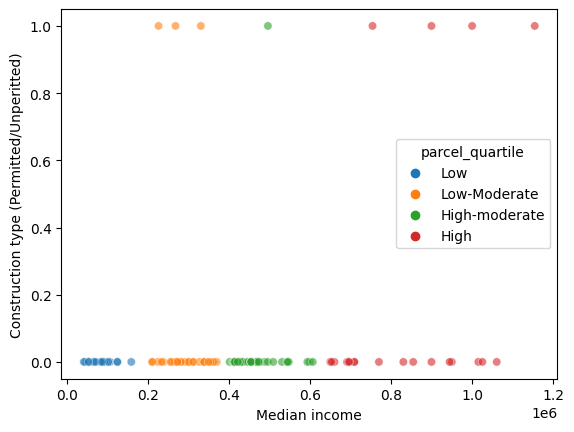

In [137]:
ax = sns.scatterplot(new_sbuild_parcel_inc, x='parcel_income', y='Permitted', hue='parcel_quartile', alpha=0.6)
ax.set(xlabel='Median income', ylabel='Construction type (Permitted/Unperitted)')
plt.show()

In [138]:
outcome = new_sbuild_parcel_inc.groupby('parcel_quartile').agg(
    {'Permitted': 'sum', 'APN': 'count'}).reset_index()
outcome

,parcel_quartile,Permitted,APN
0,Low,0,18
1,Low-Moderate,3,31
2,High-moderate,1,33
3,High,4,21


In [139]:
low = outcome.loc[outcome['parcel_quartile'] != 'High']
high = outcome.loc[outcome['parcel_quartile'] == 'High']
baseline = low['Permitted'].sum() / low['APN'].sum() * 100
high_level = high['Permitted'].sum() / high['APN'].sum() * 100

effect_size = high_level - baseline

print('[INFO] Baseline: {}; Effect size: {}'.format(round(baseline, 1), round(effect_size, 1)))

[INFO] Baseline: 4.9; Effect size: 14.2


In [ ]:
2.5, 21.5

In [ ]:
4.8; 14.2